In [1]:
import wave
import glob
import random

# for data, model, training
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from scipy import signal

import librosa
import librosa.display

# for visuals and statistics
import matplotlib.pyplot as plt
import seaborn as sns

# Set the seed value for experiment reproducibility.
seed = 42
random.seed(42)
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
def get_and_shuffle_filenames(dir_name):
    filenames = glob.glob(str(data_dir) + "/*")
    random.shuffle(filenames)
    return filenames

data_dir = "../recordings"
filenames = get_and_shuffle_filenames(data_dir)

print(filenames[:5])

['../recordings/2_jackson_13.wav', '../recordings/6_george_34.wav', '../recordings/7_george_5.wav', '../recordings/1_yweweler_21.wav', '../recordings/2_george_42.wav']


In [3]:
# https://www.tensorflow.org/tutorials/audio/simple_audio

def decode_audio(file_path):
    # read file to get buffer                                                                                               
    ifile = wave.open(file_path)
    samples = ifile.getnframes()
    audio = ifile.readframes(samples)

    # convert buffer to float32 using NumPy                                                                                 
    audio_as_np_int16 = np.frombuffer(audio, dtype=np.int16)
    audio_as_np_float32 = audio_as_np_int16.astype(np.float32)
    
    # get largest absolute value
    max_val = np.max(
        np.absolute(
            [np.max(audio_as_np_float32), np.min(audio_as_np_float32)]))
    audio_normalized = audio_as_np_float32 / max_val

    return audio_normalized

def get_label(file_path):
    # label is in the filename
    parts = file_path.split("/")
    label = int(parts[2].split("_")[0])

    return label


In [4]:
# to remove outliers 
X_unfiltered = [(file_path, decode_audio(file_path)) for file_path in filenames]
X_lengths = [audio.shape[0] for _, audio in X_unfiltered]

max_length = int(np.mean(X_lengths) + 2 * np.std(X_lengths))
max_length = int(np.ceil(5861 / 256) * 256)
print(np.mean(X_lengths))
print(np.std(X_lengths))
print(max_length)

3499.4746666666665
1180.9471707171701
5888


In [7]:
def mel_spec(signal):
    mel = librosa.feature.melspectrogram(y=signal, sr=8000, n_fft=256, hop_length=256)
    mel = librosa.power_to_db(mel, ref=np.max)
    return mel


def spect(signal):
    spectogram = []
    for i in range(23):
        window_fft = np.fft.rfft(signal[i * 256: (i + 1) * 256])
        window_fft = list(np.abs(window_fft))
        spectogram.append(window_fft)
    spectogram = np.array(spectogram)
    spectogram = librosa.power_to_db(spectogram, ref=np.max)
    return np.transpose(spectogram)

In [20]:
# padding function from
# https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5

X_full = [] # padded X values
y_full = []

numbers = [0] * 10

for file_path, audio in X_unfiltered:
    x_val = audio
    y_val = get_label(file_path)
    
    signal_length = audio.shape[0]
    if signal_length > max_length:
        numbers[y_val] += 1
    else:
        pad_len = max_length - signal_length
        
        x_val = np.pad(
            x_val, (0, pad_len), 
            'constant', constant_values=(0, 0))
        
#         mel_x = mel_spec(x_val)
        s_x = spect(x_val)
        s_x = s_x.flatten()
        
        X_full.append(s_x)
        y_full.append(y_val)

X_full = np.array(X_full)
y_full = np.array(y_full)

print(X_full.shape)

num_samples, sample_w = X_full.shape
print(num_samples)
print(sample_w)

print(y_full[:10])

(2913, 2967)
2913
2967
[2 6 7 1 2 6 6 4 8 3]


In [21]:
# quantities = {"y": list(range(10)), "quantities": numbers}
df = pd.DataFrame.from_dict({"quantities": numbers})
print(df)
print(sum(numbers))

   quantities
0          10
1           8
2           6
3           5
4           3
5           6
6          22
7          11
8           6
9          10
87


In [22]:
mean = np.mean(X_full)
std = np.std(X_full)
X_full = X_full - mean
X_full = X_full / std

In [23]:
# rows = 3
# cols = 3
# n = rows * cols
# fig, axes = plt.subplots(rows, cols, figsize=(12, 14))

# for i, (audio, label) in enumerate(list(zip(X_full, y_full))[:n]):
#     r = i // cols
#     c = i % cols
#     ax = axes[r][c]
    
#     librosa.display.specshow(audio, sr=8000, hop_length=256, x_axis='time', ax=axes[r][c])
# #     librosa.display.specshow(audio, y_axis='mel', fmax=8000, x_axis='time', ax=axes[r][c]);
# #     plt.title('Mel Spectrogram');
# #     plt.colorbar(format='%+2.0f dB');
    
# #     ax.plot(audio)
# #     ax.set_yticks(np.arange(-1,1.5,0.5))
#     ax.set_title(label)

# plt.show()

In [24]:
tenth = int(num_samples * 0.1)
eightyth = tenth * 8

X_train = X_full[:eightyth]
y_train = y_full[:eightyth]

X_val = X_full[eightyth: eightyth + tenth]
y_val = y_full[eightyth: eightyth + tenth]

X_test = X_full[eightyth + tenth:]
y_test = y_full[eightyth + tenth:]

print('Training set size', len(X_train))
print('Validation set size', len(X_val))
print('Test set size', len(X_test))

Training set size 2328
Validation set size 291
Test set size 294


In [26]:
# INPUTS ARE NORMALIZED

model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.Input(shape=(sample_w,)))
model.add(tf.keras.layers.Reshape((129, 23, 1), input_shape=(sample_w,)))
model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
model.add(tf.keras.layers.Conv2D(64, 3, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

model.build()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 129, 23, 1)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 127, 21, 32)       320       
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 19, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 9, 64)        0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 62, 9, 64)         0         
                                                                 
 flatten_1 (Flatten)         (None, 35712)             0         
                                                      

In [27]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer="adam",
             metrics=["accuracy"])

In [28]:
history = model.fit(X_train, y_train, epochs=30,
                   validation_data=(X_val, y_val))

Epoch 1/30
73/73 [==============================] - 10s 133ms/step - loss: 2.3385 - accuracy: 0.1400 - val_loss: 2.2213 - val_accuracy: 0.1684
Epoch 2/30
73/73 [==============================] - 9s 119ms/step - loss: 2.2080 - accuracy: 0.1675 - val_loss: 2.1391 - val_accuracy: 0.2234
Epoch 3/30
73/73 [==============================] - 8s 108ms/step - loss: 2.0161 - accuracy: 0.2857 - val_loss: 1.7237 - val_accuracy: 0.4948
Epoch 4/30
73/73 [==============================] - 9s 117ms/step - loss: 1.6799 - accuracy: 0.4051 - val_loss: 1.2870 - val_accuracy: 0.6392
Epoch 5/30
73/73 [==============================] - 10s 140ms/step - loss: 1.3426 - accuracy: 0.5047 - val_loss: 0.9344 - val_accuracy: 0.7904
Epoch 6/30
73/73 [==============================] - 12s 162ms/step - loss: 1.1393 - accuracy: 0.5936 - val_loss: 0.7179 - val_accuracy: 0.8557
Epoch 7/30
73/73 [==============================] - 8s 109ms/step - loss: 0.9576 - accuracy: 0.6628 - val_loss: 0.7031 - val_accuracy: 0.8076
Epo

In [29]:
model.evaluate(X_test, y_test)

10/10 [==============================] - 0s 21ms/step - loss: 0.1848 - accuracy: 0.9354


[0.1848309338092804, 0.9353741407394409]

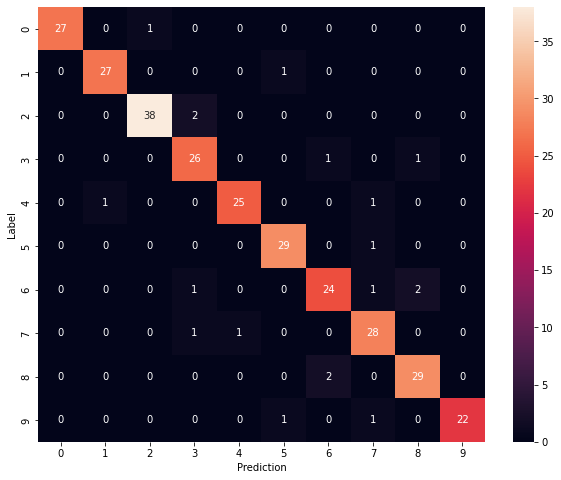

In [30]:
y_pred = np.argmax(model.predict(X_test), axis=1)

all_labels = list(range(10))

confusion_mtx = tf.math.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=all_labels,
            yticklabels=all_labels,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [43]:
# model.save("model_v5.h5")